# Data Augmentation

- Data augmentation is a technique to artificially create new training data from existing training data.

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [ ]:
#Install tensorflow dataset to fetch that data 

In [2]:
!pip install tensorflow_datasets

  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21502 sha256=abf553a823fdfa8c142102a751636c787e56ca138b2eb020aafaf7dc8fc643b7
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\e1\e8\83\ddea66100678d139b14bc87692ece57c6a2a937956d2532608
Successfully built promise


# Load Dataset Citrus Leaves

In [86]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'citrus_leaves',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

# Classes in the Dataset

In [87]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

4


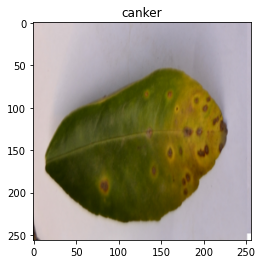

In [88]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

# Rescaling and Resizing by using Keras

In [89]:
IMG_SIZE = 150

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

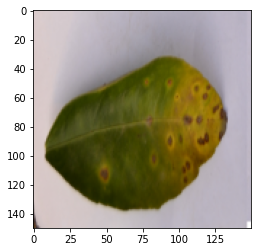

In [90]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

## Image pixels are in between 0 and 1

In [91]:
print("Min and max image pixel values:", result.numpy().min(), result.numpy().max())

Min and max image pixel values: 0.0 1.0


# Data Agumentation Implementation
    
   - Used RandonFlip and RandomRotation in this model we can also use others such as RandomZoon and vice versa.
    

In [92]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

## Shape of One Augmented Image

In [58]:
augmented_image=data_augmentation(image)

In [59]:
augmented_image.shape

TensorShape([256, 256, 3])

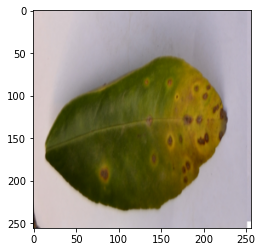

In [60]:
plt.imshow(image)

In [93]:
# Add the image to a batch.
image = tf.expand_dims(image, 0)

## Applied 16 Augmentation

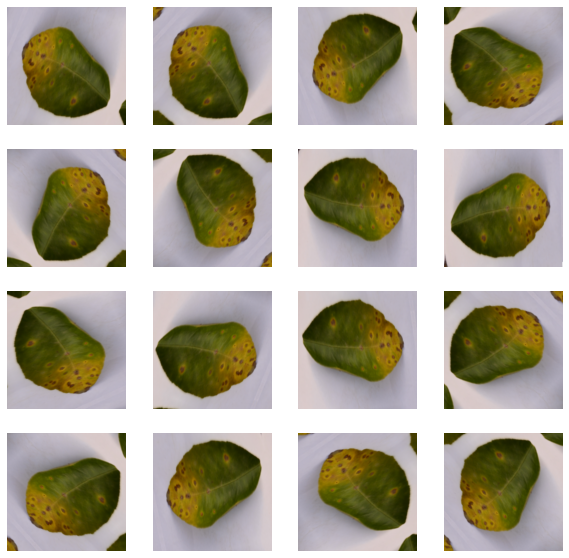

In [94]:
plt.figure(figsize=(10, 10))
for i in range(16):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

# Model Building
- Preprocessing layer which was created earlier is included in the first option
- Preprocessing layer is applying in the second option

## Option 1

In [95]:
model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model.
])

## Option 2

In [80]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

In [81]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)
  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [96]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

# Train the Model by using CNN
- It consists of three convolutional layes with a max pooling layer. We applied RELU on activation and padding applied "same" instead of "valid". 

In [100]:
model = tf.keras.Sequential([
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(16, activation='relu'),
  layers.Dense(num_classes)
])

## Model Compilation
- Used adam as optimizer
- Run 5 Epochs

In [101]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [102]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
11/11 [==============================] - 33s 3s/step - loss: 1.1232 - accuracy: 0.4235 - val_loss: 0.9391 - val_accuracy: 0.5476
Epoch 2/5
11/11 [==============================] - 32s 3s/step - loss: 1.0151 - accuracy: 0.4735 - val_loss: 0.9959 - val_accuracy: 0.5476
Epoch 3/5
11/11 [==============================] - 32s 3s/step - loss: 0.9919 - accuracy: 0.4500 - val_loss: 0.8646 - val_accuracy: 0.5714
Epoch 4/5
11/11 [==============================] - 32s 3s/step - loss: 0.8462 - accuracy: 0.6000 - val_loss: 0.6640 - val_accuracy: 0.7857
Epoch 5/5
11/11 [==============================] - 32s 3s/step - loss: 0.6813 - accuracy: 0.7059 - val_loss: 0.5721 - val_accuracy: 0.8095


## Model Evaluation

In [26]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

2/2 [==============================] - 1s 82ms/step - loss: 0.6725 - accuracy: 0.6512
Accuracy 0.6511628031730652


# Custom data augmentation
create custom data augmentation layers.

This section of the tutorial shows two ways of doing so:

First, create a tf.keras.layers.Lambda layer. This is a good way to write concise code.
Next, you will write a new layer via subclassing, which gives you more control.
Both layers will randomly invert the colors in an image, according to some probability.

In [29]:
def random_invert_img(x, p=0.5):
    if  tf.random.uniform([]) < p:
        x = (255-x)
    else:
        x
    return x

In [32]:
def random_invert(factor=0.5):
    return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

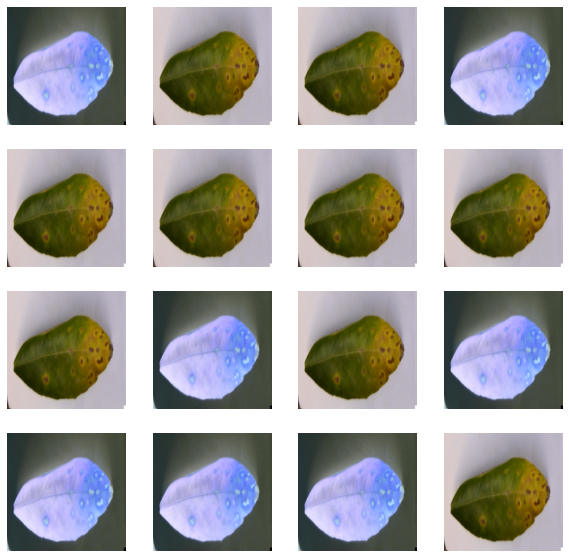

In [33]:
plt.figure(figsize=(10, 10))
for i in range(16):
    augmented_image = random_invert(image)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")

# Conclusion
- Model prediction accuracy is improved in the Data Augmentation.
- It added more training data.
- It increased the generalization of the model